<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Анализ-концентрации-металлов" data-toc-modified-id="Анализ-концентрации-металлов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ концентрации металлов</a></span></li><li><span><a href="#Анализ-распределение-гранул-сырья" data-toc-modified-id="Анализ-распределение-гранул-сырья-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Анализ распределение гранул сырья</a></span></li><li><span><a href="#Анализ-суммарной-концентрации-веществ" data-toc-modified-id="Анализ-суммарной-концентрации-веществ-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Анализ суммарной концентрации веществ</a></span></li></ul></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Функция-для-вычисления-sMAPE" data-toc-modified-id="Функция-для-вычисления-sMAPE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Функция для вычисления sMAPE</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные находятся в трёх файлах:
* 		gold_recovery_train_new.csv — обучающая выборка;
* 		gold_recovery_test_new.csv — тестовая выборка;
* 		gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

## Подготовка данных

In [1]:
# Загрузим все необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Выведем данные:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

data = [data_train, data_test, data_full]
for i in data:
    i.info()
    display(i.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Есть незначительные пропуски в данных, их нужно будет заполнить.

In [3]:
# Проверим, что эффективность обогащения рассчитана правильно.
# Необходимо рассчитать её на обучающей выборке для признака rougher.output.recovery
# C — доля золота в концентрате после флотации/очистки.
C = data_train['rougher.output.concentrate_au']
# F — доля золота в сырье/концентрате до флотации/очистки.
F = data_train['rougher.input.feed_au']
# T — доля золота в отвальных хвостах после флотации/очистки.
T = data_train['rougher.output.tail_au']

recovery = 100 * (C * (F - T)) / (F * (C - T))
print('MAE:', mean_absolute_error(data_train['rougher.output.recovery'], recovery))

MAE: 1.1131451184435918e-14


Степень погрешности в данных MAE близка к 0 - данные верны.

In [4]:
# Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
test_columns = list(set(data_test.columns) ^ set(data_full.columns))
print(*sorted(test_columns), sep = "\n")

final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_au
secondary_cleaner.

В тестовой выборке отсутствуют все параметры продукта output в финальных характеристиках, первичной и вторичной очистках, флотации, а также расчетные характеристики во флотации.

In [5]:
# Проведем предобработку данных - заполним пропуски в датасетах data_test и data_train:
data_test = data_test.ffill()
data_train = data_train.ffill()
data_test.info()
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

**Вывод:** Пропуски заполнены.

## Анализ данных

### Анализ концентрации металлов

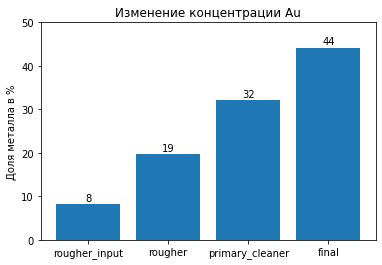

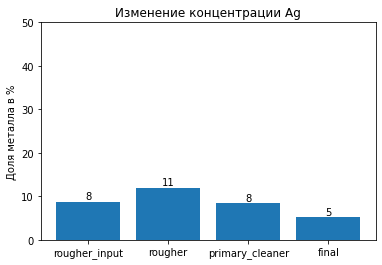

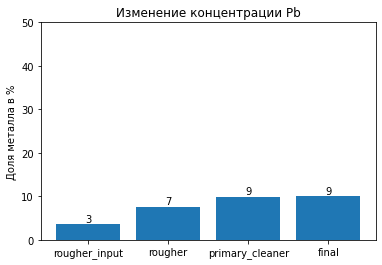

In [6]:
# Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки:
au_concentrate = [data_full['rougher.input.feed_au'].mean(),
                  data_full['rougher.output.concentrate_au'].mean(),
                  data_full['primary_cleaner.output.concentrate_au'].mean(),
                  data_full['final.output.concentrate_au'].mean()]

ag_concentrate = [data_full['rougher.input.feed_ag'].mean(),
                  data_full['rougher.output.concentrate_ag'].mean(),
                  data_full['primary_cleaner.output.concentrate_ag'].mean(),
                  data_full['final.output.concentrate_ag'].mean()]

pb_concentrate = [data_full['rougher.input.feed_pb'].mean(),
                  data_full['rougher.output.concentrate_pb'].mean(),
                  data_full['primary_cleaner.output.concentrate_pb'].mean(),
                  data_full['final.output.concentrate_pb'].mean()]

metal = [au_concentrate, ag_concentrate, pb_concentrate]
process = ['rougher_input', 'rougher', 'primary_cleaner','final']

def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')
        
for i in metal:
        plt.bar(process, i)
        if i == au_concentrate:
            plt.title('Изменение концентрации Au')
        elif i == ag_concentrate:
            plt.title('Изменение концентрации Ag')
        else:
            plt.title('Изменение концентрации Pb')
        plt.ylabel('Доля металла в %')
        plt.ylim([0, 50])
        ax = plt.gca()
        autolabel(ax.patches, height_factor=1.01)
        plt.show()

**Вывод:** За время переработки больше всего изменяется концентрация Золота с 8 до 44%. Концентрация Серебра снизилась с 8 до 5%. Концетрация Свинца незначительно выросла с 3 до 9%.

### Анализ распределение гранул сырья

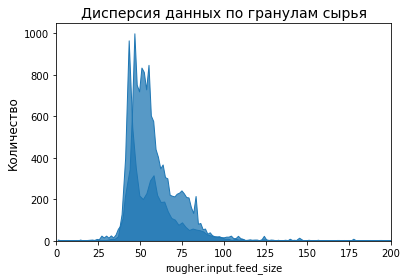

In [7]:
# Сравним распределение размеров гранул сырья на обучающей и тестовой выборках.
# Если распределения сильно отличаются друг от друга, оценка модели будет неправильной:
sns.histplot(data=data_test['rougher.input.feed_size'], element="poly")
sns.histplot(data=data_train['rougher.input.feed_size'], element="poly")
plt.title('Дисперсия данных по гранулам сырья', fontsize=14)
plt.ylabel('Количество', fontsize=12)
plt.xlim([0, 200])
plt.show()

**Вывод:** Распределение значений в тестовой и обучающей выборок практически одинаково.

### Анализ суммарной концентрации веществ

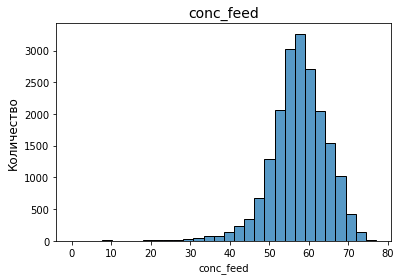

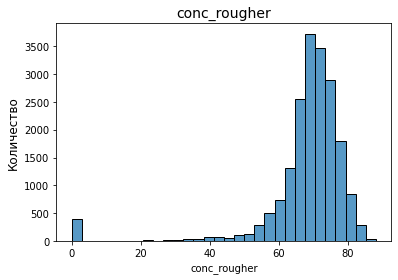

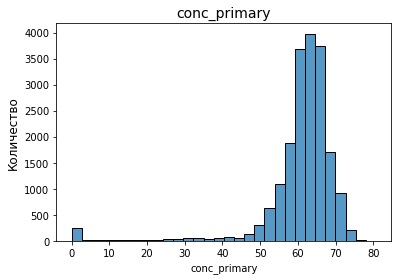

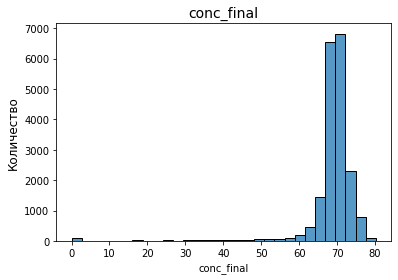

In [8]:
# Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах:
data_full['conc_feed'] = data_full['rougher.input.feed_ag'] + data_full['rougher.input.feed_pb'] +\
                          data_full['rougher.input.feed_sol'] + data_full['rougher.input.feed_au']
data_full['conc_rougher'] = data_full['rougher.output.concentrate_ag'] + data_full['rougher.output.concentrate_pb'] +\
                          data_full['rougher.output.concentrate_sol'] + data_full['rougher.output.concentrate_au']
data_full['conc_primary'] = data_full['primary_cleaner.output.concentrate_ag'] + data_full['primary_cleaner.output.concentrate_pb'] +\
                          data_full['primary_cleaner.output.concentrate_sol'] + data_full['primary_cleaner.output.concentrate_au']
data_full['conc_final'] = data_full['final.output.concentrate_ag'] + data_full['final.output.concentrate_pb'] +\
                          data_full['final.output.concentrate_sol'] + data_full['final.output.concentrate_au']

tables_conc = ['conc_feed', 'conc_rougher', 'conc_primary', 'conc_final']
    
for i in tables_conc:
    sns.histplot(data=data_full[i], bins=30)
    plt.title(i, fontsize=14)
    plt.ylabel('Количество', fontsize=12)
    plt.show()

**Вывод:** Есть строки с нулевыми суммарными значениями, особенно в стадии флотации и первичной очистки. Необходимо их удалить, т.к. такое практически невозможно.

In [9]:
# Удалим строки с нулевыми суммарными значениями из обучающей и тестовой выборок:
data_filt = data_full.query('conc_feed ==0 | conc_rougher ==0 | conc_primary == 0| conc_final ==0')
data_filt = data_filt['date'].reset_index(drop=True)
data_train = data_train.loc[~data_train['date'].isin(data_filt)]
data_test = data_test.loc[~data_test['date'].isin(data_filt)]

## Модель

### Функция для вычисления sMAPE

In [10]:
# Напишем функцию для вычисления итоговой sMAPE.
def smape(target, predict):
    if not all([isinstance(target, np.ndarray), 
                isinstance(predict, np.ndarray)]):
        target, predict = np.array(target), np.array(predict)
    
    return 1/len(target) * np.sum(2*np.abs(predict-target)/(np.abs(target)+np.abs(predict))*100)

smape_scorer = make_scorer(score_func=smape, greater_is_better = False)

### Обучение моделей

In [11]:
# Извлечем признаки и целевые признаки:
features_final_train = data_train[data_test.columns].drop(columns='date')
features_rougher_train = features_final_train[[x for x in features_final_train.columns if 'rougher' in x]]
target_rougher_train = data_train['rougher.output.recovery']
target_final_train = data_train['final.output.recovery']
features_rougher_test = data_test[[x for x in features_final_train.columns if 'rougher' in x]]
features_final_test = data_test.drop(columns='date')

In [12]:
# Создадим два тестовых таргета: 
data_filt_test = data_test['date'].reset_index(drop=True)
target_filt_test = data_full.query("date in @data_filt_test")
target_rougher_test = target_filt_test['rougher.output.recovery']
target_final_test = target_filt_test['final.output.recovery']

In [14]:
# Распечатаем размеры выборок:
df = features_rougher_train, target_rougher_train, features_final_train, target_final_train,\
features_rougher_test, target_rougher_test, features_final_test, target_final_test

for i in df:
    display(i.shape)

(13725, 22)

(13725,)

(13725, 52)

(13725,)

(5123, 22)

(5123,)

(5123, 52)

(5123,)

In [15]:
grid_DT_rougher = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345), 
                               param_grid={'max_depth':[1,2,3,4,5,6,7,8,9,10]}, 
                               scoring=smape_scorer).fit(features_rougher_train, target_rougher_train)
print(-1*grid_DT_rougher.best_score_)
print(grid_DT_rougher.best_params_)

7.026963127425681
{'max_depth': 4}


In [16]:
grid_DT_final = GridSearchCV(estimator=DecisionTreeRegressor(random_state=12345), 
                               param_grid={'max_depth':[1,2,3,4,5,6,7,8,9,10]}, 
                               scoring=smape_scorer).fit(features_final_train, target_final_train)
print(-1*grid_DT_final.best_score_)
print(grid_DT_final.best_params_)

9.440354196471514
{'max_depth': 3}


In [17]:
grid_RF_rougher = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), 
                               param_grid={'max_depth':[1,2,3,4,5,6,7,8,9,10], 'n_estimators':[10,20,30,40,50]}, 
                               scoring=smape_scorer).fit(features_rougher_train, target_rougher_train)
print(-1*grid_RF_rougher.best_score_)
print(grid_RF_rougher.best_params_)

6.592060303322273
{'max_depth': 5, 'n_estimators': 30}


In [18]:
grid_RF_final = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), 
                               param_grid={'max_depth':[1,2,3,4,5,6,7,8,9,10], 'n_estimators':[10,20,30,40,50]}, 
                               scoring=smape_scorer).fit(features_final_train, target_final_train)
print(-1*grid_RF_final.best_score_)
print(grid_RF_final.best_params_)

9.016173429845159
{'max_depth': 4, 'n_estimators': 50}


In [19]:
# Обучим разные модели и оценим их качество кросс-валидацией:
models = [LinearRegression(), DecisionTreeRegressor(random_state=12345, max_depth=3), 
          RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=50)]

for model in models:
    smape_rougher = cross_val_score(model, features_rougher_train, target_rougher_train, scoring=smape_scorer, cv=3)
    smape_final = cross_val_score(model, features_final_train, target_final_train, scoring=smape_scorer, cv=3)
    print(model)
    print('sMAPE этап флотации:', -1 * np.mean(smape_rougher).round(2), "%")
    print('sMAPE финальный этап:', -1 * np.mean(smape_final).round(2), "%")
    print('Итоговый sMAPE:', -1 * np.mean(0.25 * smape_rougher + 0.75 * smape_final).round(2), "%")
    print()

LinearRegression()
sMAPE этап флотации: 9.01 %
sMAPE финальный этап: 13.42 %
Итоговый sMAPE: 12.32 %

DecisionTreeRegressor(max_depth=3, random_state=12345)
sMAPE этап флотации: 8.43 %
sMAPE финальный этап: 11.18 %
Итоговый sMAPE: 10.5 %

RandomForestRegressor(max_depth=4, n_estimators=50, random_state=12345)
sMAPE этап флотации: 7.74 %
sMAPE финальный этап: 10.92 %
Итоговый sMAPE: 10.12 %



**Вывод:** Для флотации и финального этапа лучше всего подойдет модель RandomForestRegressor - наименьший sMAPE 9.54%.

In [20]:
# Проверим модель на тестовой выборке:
model = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=50)

model_rougher = model.fit(features_rougher_train, target_rougher_train)
predictions_rougher_test = model_rougher.predict(features_rougher_test)
smape_test_rougher = smape(target_rougher_test, predictions_rougher_test)
print('sMAPE rougher test:', smape_test_rougher)

model_final = model.fit(features_final_train, target_final_train)
predictions_final_test = model_final.predict(features_final_test)
smape_test_final = smape(target_final_test, predictions_final_test)
print('sMAPE final test:', smape_test_final)

smape_test_total = 0.25 * smape_test_rougher + 0.75 * smape_test_final
print('Итоговый sMAPE test',smape_test_total)

sMAPE rougher test: 4.874668201018448
sMAPE final test: 8.20666817953057
Итоговый sMAPE test 7.37366818490254


**Вывод:** На тестовой выборке хорошие показатели по метрике sMAPE.

In [21]:
# Для проверки модели рассчитаем значения sMAPE через DummyRegressor:
dummy_regressor_rougher = DummyRegressor(strategy="median")
dummy_regressor_rougher.fit(features_rougher_train, target_rougher_train)
dummy_rougher_pred = dummy_regressor_rougher.predict(features_rougher_test)
smape_dummy_rougher = smape(target_rougher_test, dummy_rougher_pred)
print('sMAPE dummy rougher', smape_dummy_rougher) 
dummy_regressor_final = DummyRegressor(strategy="median")
dummy_regressor_final.fit(features_final_train, target_final_train)
dummy_final_pred = dummy_regressor_final.predict(features_final_test)
smape_dummy_final = smape(target_final_test, dummy_final_pred)
print('sMAPE dummy final', smape_dummy_final)
smape_dummy_total = 0.25 * smape_dummy_rougher + 0.75 * smape_dummy_final
print('Итоговый sMAPE dummy',smape_dummy_total)

sMAPE dummy rougher 4.809033066029801
sMAPE dummy final 8.222545492433415
Итоговый sMAPE dummy 7.369167385832512


**Вывод:** Итоговый sMAPE dummy модели чуть хуже обученной модели.

**Итоговый вывод:** По результатам анализа и обучения модели удалось найти оптимальную модель для предсказания коэффициента восстановления золота из золотосодержащей руды.